In [2]:
import torch
import torch.nn as nn 
import pandas as pd
import numpy as np
import time
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import datetime

In [3]:
from src.algorithms.LSTMAutoencoder import LSTMAutoencoderAlgo
from src.utils.util import *
from src.dataset.yahoo import YahooDataset
from src.model.modelLSTM import Encoder,Decoder,LSTMAutoencoder

In [4]:
#This is the beginning of programm
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)
print(current_time)

12:43:53


<h4>Initializing Dataset</h4>

In [5]:
class ArgsTrn:
    workers=4
    batch_size=32
    epochs=5
    lr=0.0002
    cuda = True
    manualSeed=2
    mean=0
    std=0.1
    
opt_trn=ArgsTrn()
torch.manual_seed(opt_trn.manualSeed)


class DataSettings:
    def __init__(self):
        
        self.data_folder_path='/home/jupyter/GRANOGAN-IISC/data/yahoo/A1Benchmark/'
        self.train = True
        self.window_length = 60
data_settings = DataSettings()

In [6]:
# define dataset object and data loader object for NAB dataset
dataset = YahooDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature
n_features=dataset.x.shape[2]
sequences=[x for i, (x,y) in enumerate(dataloader, 0)]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [8]:
dataset.x.shape
embedding_dim=16

In [9]:
lstmAutoencoderAlgo=LSTMAutoencoderAlgo(device=device,opt_trn=opt_trn,windows_length=seq_len,n_features=n_features,embedding_dim=embedding_dim)

In [10]:
trained_autoencoder=lstmAutoencoderAlgo.train_autoencoder(sequences)

Epoch 0: train loss 0.97610308568586
Epoch 1: train loss 0.7336692671206865
Epoch 2: train loss 0.5287130304019559
Epoch 3: train loss 0.49193686873398046
Epoch 4: train loss 0.48918687738478184


In [11]:
PATH='/home/jupyter/GRANOGAN-IISC/src/saved_models/LSTMAutoencoder/yahoo/autoencoder.pkl'

In [12]:
torch.save(trained_autoencoder.module.state_dict(), PATH)

In [13]:
state_dict = torch.load(PATH)
trained_autoencoder=LSTMAutoencoder(embedding_dim, n_features,device=device)
trained_autoencoder=nn.DataParallel(trained_autoencoder)
trained_autoencoder.to(device)
trained_autoencoder=lstmAutoencoderAlgo.load_model(state_dict,trained_autoencoder)

<h4>Loading back the saved models</h4>

In [14]:
lstmAutoencoderAlgo.intialize_lstmautoencoder(trained_autoencoder)

<h2>Test Data</h2>


In [15]:
class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()


class TestDataSettings:
    
    def __init__(self):
        self.data_folder_path='/home/jupyter/GRANOGAN-IISC/data/yahoo/A1Benchmark/'
        self.train = False
        self.window_length = 60      
        
test_data_settings = TestDataSettings()

In [22]:
# define dataset object and data loader object in evaluation mood for NAB dataset

test_dataset = YahooDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape


test_sequences=[x for i, (x,y) in enumerate(test_dataloader, 0)]

In [23]:
losses=lstmAutoencoderAlgo.predict_loss(test_sequences)

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
print(len(losses))

23


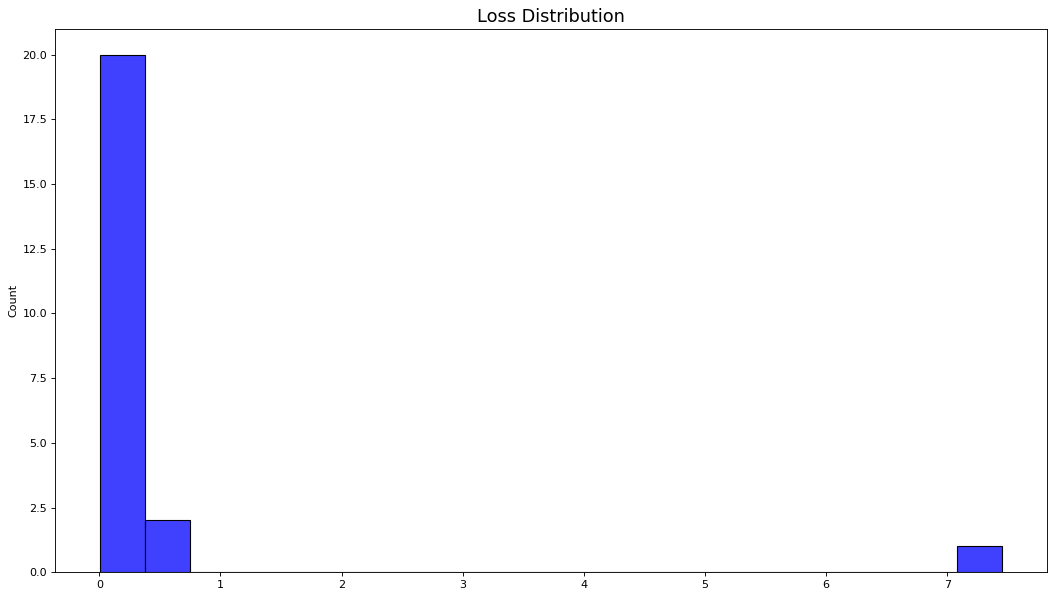

In [25]:
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.histplot(losses, bins = 20, kde= False, color = 'blue');
#sns.distplot(losses, bins = 20, kde= True, color = 'blue');

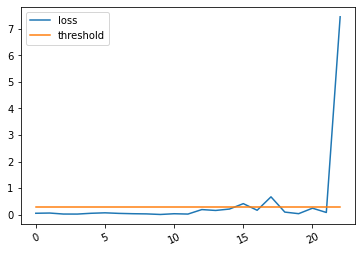

In [26]:
THRESHOLD =0.298

test_score_df = pd.DataFrame(index=range(len(losses)))
test_score_df['loss'] = [loss for loss in losses]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot( test_score_df.loss, label='loss')
plt.plot( test_score_df.threshold, label='threshold')
#plt.plot( test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend();

In [27]:
import numpy as np
actual,predicted=improve_detection(test_score_df)

In [28]:

from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

print_scores(predicted,actual)

True Positive	 1
True Negative	 20
False Positive	 2
False Negative	 0
Accuracy	 0.9130434782608695
Precision	 0.3333333333333333
Recall	 1.0
f-measure	 0.5
cohen_kappa_score	 0.4651162790697674
auc	 0.9545454545454545
roc_auc	 0.9545454545454545
